## The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally apply a color transform and append binned color features, as well as histograms of color, to the HOG feature vector.
* Normalize the features and randomize a selection for training and testing.
* Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
* Run the pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### 1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier


In [17]:
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from pathlib import Path

#declar the name of the pickle file to save
feature_vector_pickle_file = './feature_vector_pickle_YCrCb.p'
feature_vector_file = Path(feature_vector_pickle_file)

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)    

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    print('Extracting features, this may take a while...')
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# Divide up into cars and notcars
# cars
car_filepath = []
car_filepath.append('./training_set/vehicles/GTI_Far/*.png')
car_filepath.append('./training_set/vehicles/GTI_Left/*.png')
car_filepath.append('./training_set/vehicles/GTI_MiddleClose/*.png')
car_filepath.append('./training_set/vehicles/GTI_Right/*.png')
car_filepath.append('./training_set/vehicles/KITTI_extracted/*.png')
# not cars
notcar_filepath = []
notcar_filepath.append('./training_set/non-vehicles/GTI/*.png')
notcar_filepath.append('./training_set/non-vehicles/Extras/*.png')

car_images = []
notcar_images = []
for files in car_filepath:
    print('files is {}'.format(files))
    car_images = car_images + glob.glob(files)
print('Number of car images in the data set {}'.format(len(car_images)))

for files in notcar_filepath:
    print('files is {}'.format(files))
    notcar_images = notcar_images + glob.glob(files)
print('Number of non-car images in the data set {}'.format(len(notcar_images))) 

cars = []
notcars = []
for image in car_images:
        cars.append(image)
for image in notcar_images:
        notcars.append(image)        

# Only for testing, reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
reduce_sample_size_for_testing = False
if reduce_sample_size_for_testing is True:
    sample_size = 500
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]

# Apply these parameters to extract the features.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True # Spatial features on or off
hist_feat = True    # Histogram features on or off
hog_feat = True     # HOG features on or off


# check if we already created the feature vectors
if feature_vector_file.is_file():
    print('Feature vectors are already created')
    # load the feature vectors and corresponding parameters
    with open(feature_vector_pickle_file, mode='rb') as f:
        dist_pickle = pickle.load(f)
        svc = dist_pickle["svc"]
        color_space = dist_pickle["color_space"]
        X_scaler = dist_pickle["scaler"]
        orient = dist_pickle["orient"]
        pix_per_cell = dist_pickle["pix_per_cell"]
        cell_per_block = dist_pickle["cell_per_block"]
        spatial_size = dist_pickle["spatial_size"]
        hist_bins = dist_pickle["hist_bins"]
    print('Model trained using:',color_space,'color space |',orient,'orientations |',pix_per_cell,
        'pixels per cell |', cell_per_block,'cells per block |', hog_channel, 'hog channel')
else:
    t=time.time()
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',color_space,'color space |',orient,'orientations |',pix_per_cell,
        'pixels per cell |', cell_per_block,'cells per block |', hog_channel, 'hog channel')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    # save the result for later use    
    dist_pickle = {}
    dist_pickle["svc"] = svc
    dist_pickle["color_space"] = color_space    
    dist_pickle["scaler"] = X_scaler
    dist_pickle["orient"] = orient
    dist_pickle["pix_per_cell"] = pix_per_cell   
    dist_pickle["cell_per_block"] = cell_per_block
    dist_pickle["spatial_size"] = spatial_size
    dist_pickle["hist_bins"] = hist_bins   
    pickle.dump( dist_pickle, open( feature_vector_pickle_file, 'wb' ) )

files is ./training_set/vehicles/GTI_Far/*.png
files is ./training_set/vehicles/GTI_Left/*.png
files is ./training_set/vehicles/GTI_MiddleClose/*.png
files is ./training_set/vehicles/GTI_Right/*.png
files is ./training_set/vehicles/KITTI_extracted/*.png
Number of car images in the data set 6692
files is ./training_set/non-vehicles/GTI/*.png
files is ./training_set/non-vehicles/Extras/*.png
Number of non-car images in the data set 8968
Extracting features, this may take a while...
Extracting features, this may take a while...
52.05 Seconds to extract HOG features...
Using: YCrCb color space | 8 orientations | 8 pixels per cell | 2 cells per block | ALL hog channel
Feature vector length: 7872
6.77 Seconds to train SVC...
Test Accuracy of SVC =  0.9943
My SVC predicts:  [ 0.  0.  1.  0.  0.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  1.  1.  1.  1.  1.]
0.00191 Seconds to predict 10 labels with SVC


## Hog sub-sampling window search and multi-scale windows

[[(610, 400), (706, 496)], [(802, 400), (898, 496)], [(826, 400), (922, 496)], [(826, 424), (922, 520)], [(850, 400), (946, 496)], [(850, 424), (946, 520)], [(994, 400), (1090, 496)], [(1018, 400), (1114, 496)], [(1018, 424), (1114, 520)], [(1042, 400), (1138, 496)], [(1042, 424), (1138, 520)], [(1066, 400), (1162, 496)], [(1066, 424), (1162, 520)], [(1066, 448), (1162, 544)], [(1090, 400), (1186, 496)], [(1090, 424), (1186, 520)], [(1114, 424), (1210, 520)]]
length of bbox_list 17
bbox_list[0] is [(610, 400), (706, 496)]


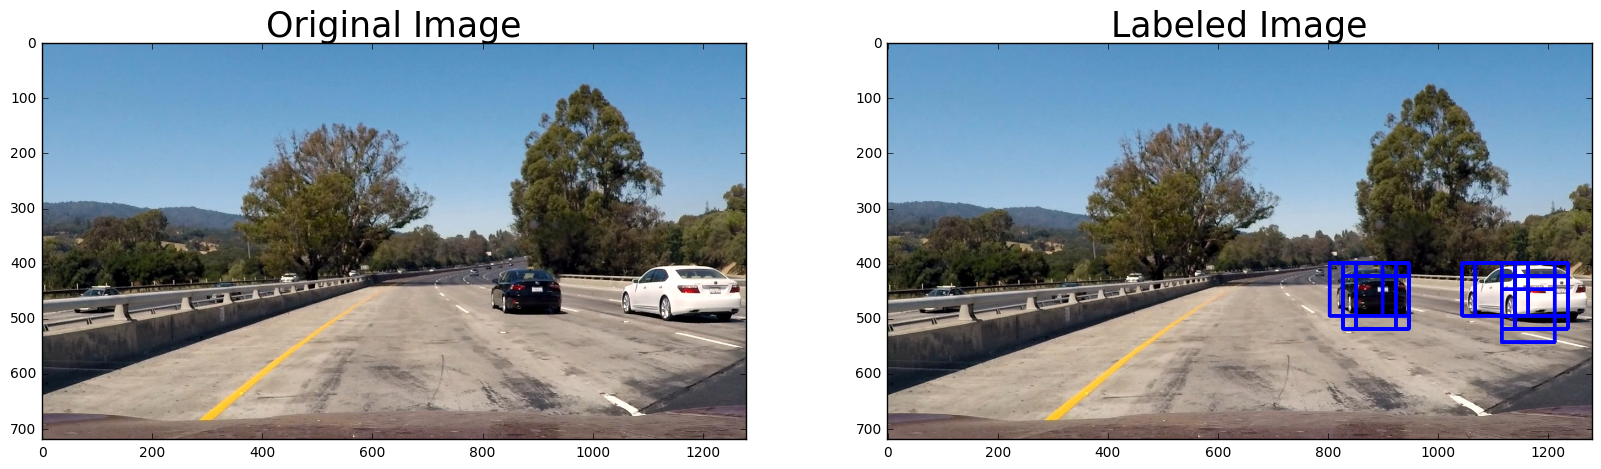

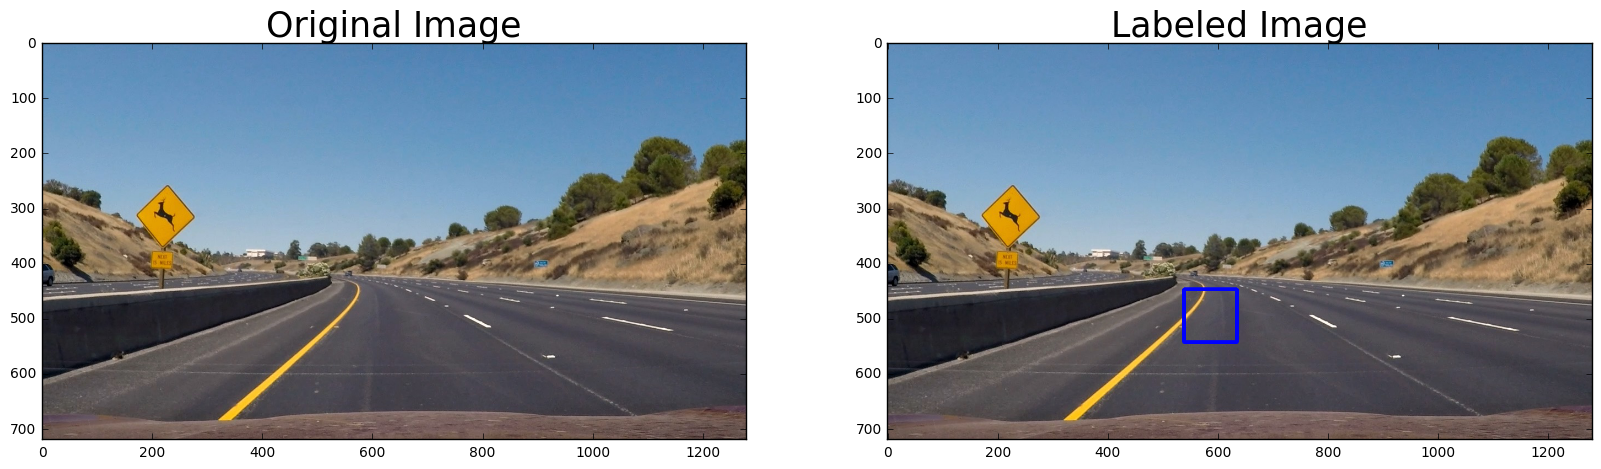

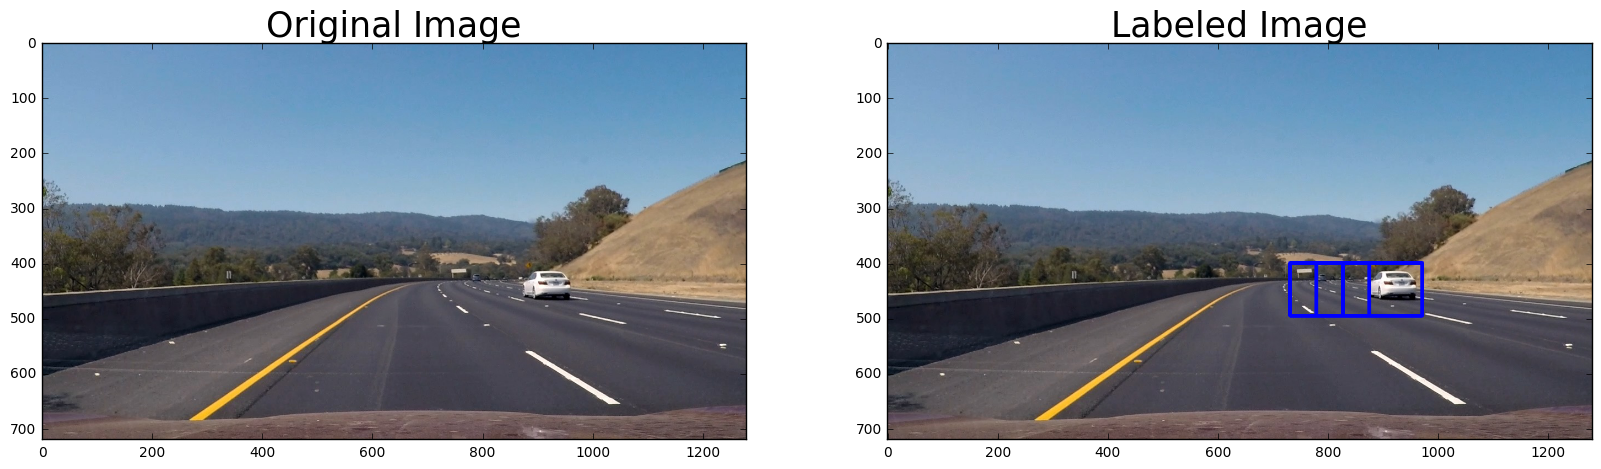

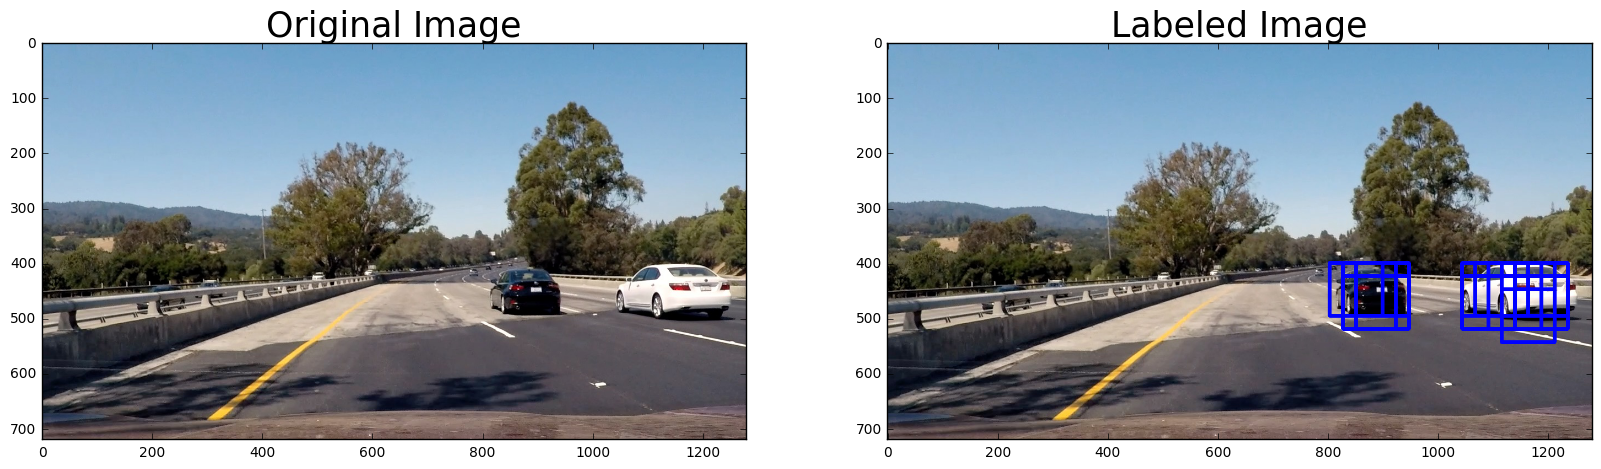

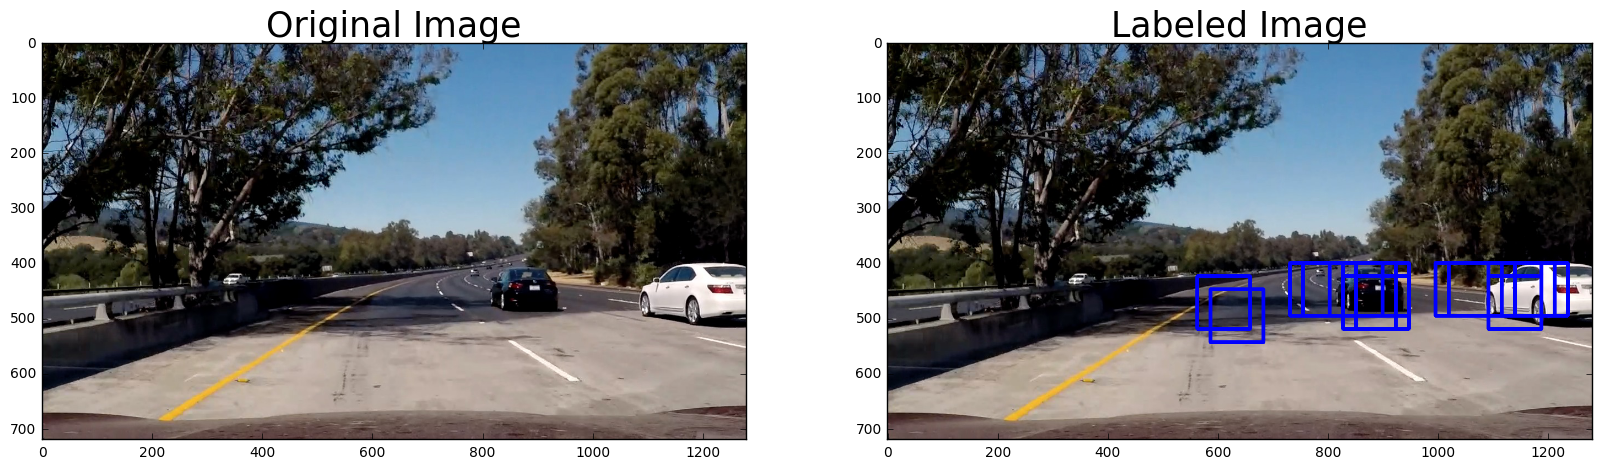

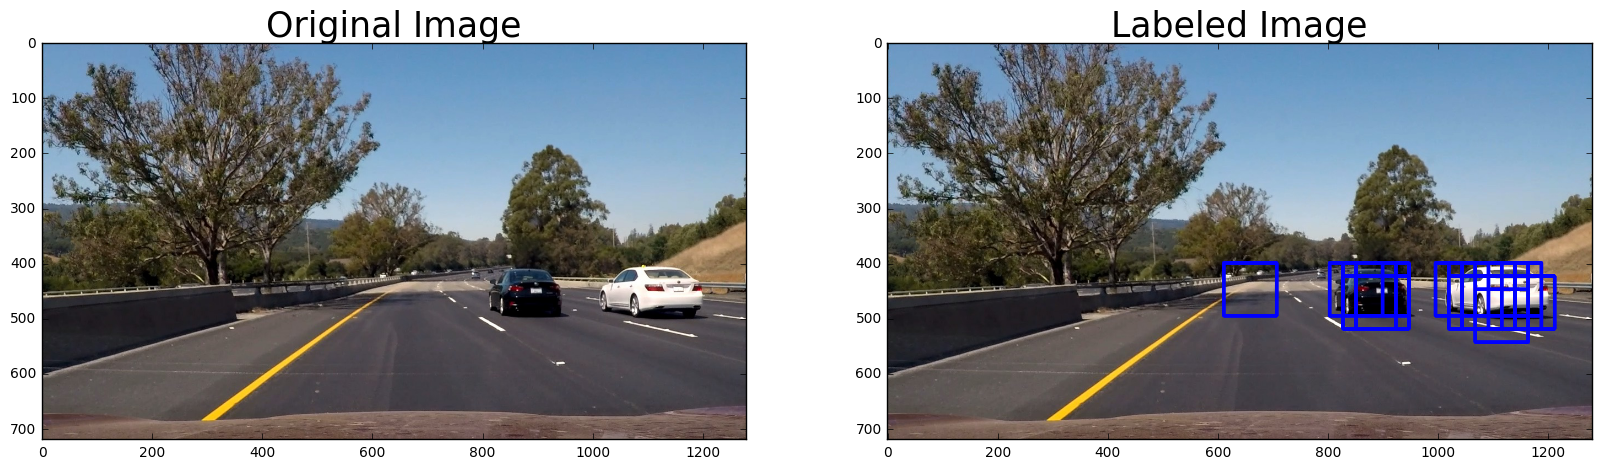

In [18]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
%matplotlib inline

# unpack the pickle file to restore parameters for function find_cars()
dist_pickle = pickle.load(open(feature_vector_pickle_file, "rb" ) )
svc = dist_pickle["svc"]
color_space = dist_pickle["color_space"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

images = glob.glob('./test_images/test*.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, region_of_interest, 
              svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, 
              vis=False, color_space = 'RGB2YCrCb'):
    
    ystart = region_of_interest[0]
    ystop = region_of_interest[1]
    xstart = region_of_interest[2]
    xstop = region_of_interest[3]
    scale = region_of_interest[4]
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop, xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox = [] # bounding box
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)+xstart# add "xstart" as an offset
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # only draw rectangle if visulization is required
                if vis is True:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                      
    return draw_img, bbox

# region definition: (ystart, ystop, xstart, xstop, scale)
#region0 = (412, 480, 442, 1280, .84)
region0 = (400, 656, 442, 1280, 1.5) # restrict xstart towards right side of the frame
region1 = (372, 540, 200, 1280, 2.)
region2 = (326, 658, 0, 1280, 3.)
region3 = (240, 700, 0, 1280, 5.6)
region_of_interests = []
region_of_interests.append(region0)
region_of_interests.append(region1) 
region_of_interests.append(region2)
region_of_interests.append(region3) 
bbox_list = []
color_conversion = 'RGB2'+ color_space
for file in images:
    img = mpimg.imread(file)
    out_img = img
    for i in range(1):
        out_img, bbox = find_cars(out_img, region_of_interests[i], 
                        svc, X_scaler, orient, 
                        pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                        vis=True, color_space=color_conversion)
        if (file=='./test_images/test6.jpg' and  i == 0):
            bbox_list = bbox
    # Visualization
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(out_img)
    ax2.set_title('Labeled Image', fontsize=25)
print(bbox_list)
print('length of bbox_list {}'.format(len(bbox_list)))
print('bbox_list[0] is {}'.format(bbox_list[0]))

## Handle multiple detection and false positives using heat map/threshold

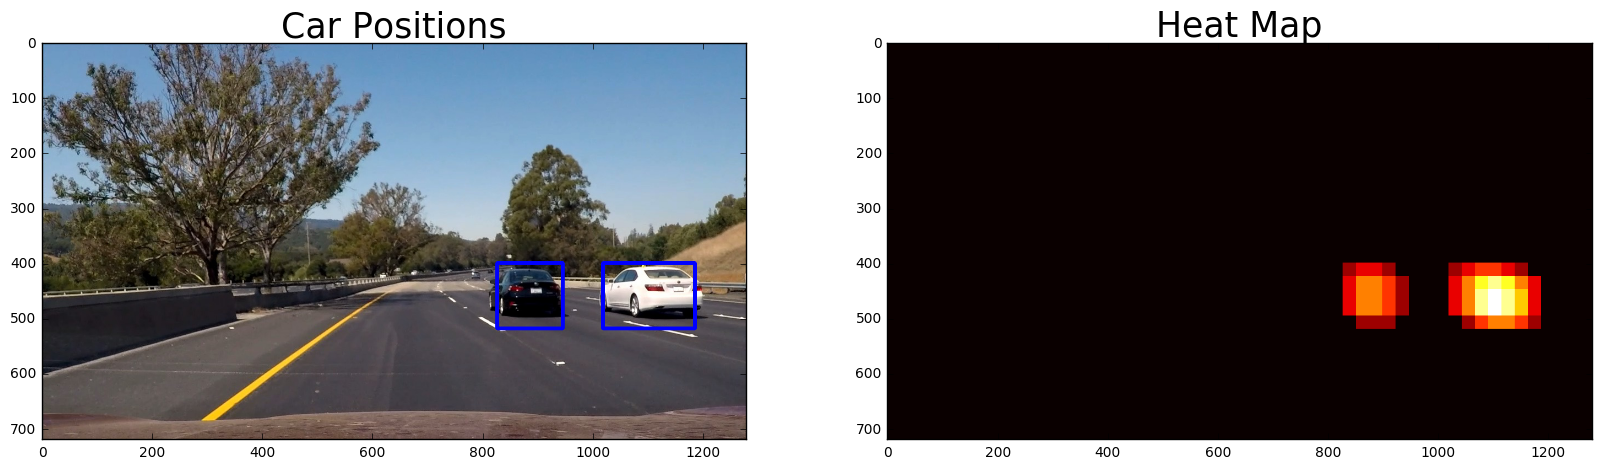

In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label


# Read in a test image
image = mpimg.imread('./test_images/test6.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # print('box is {}'.format(box))
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,bbox_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

# Visualization
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=25)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=25)

## the Tracking pipeline

In [20]:
def pipeline(img):
    out_img, bbox_list = find_cars(img, region_of_interests[i], 
                                svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

## Test the video

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_output = 'finished_test_video3.mp4'
input_clip = VideoFileClip("test_video.mp4")
# project_output = 'finished_project_video2.mp4'
# input_clip = VideoFileClip("project_video.mp4")
output_clip = input_clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video finished_test_video3.mp4
[MoviePy] Writing video finished_test_video3.mp4


 97%|█████████▋| 38/39 [00:07<00:00,  5.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: finished_test_video3.mp4 

CPU times: user 7.21 s, sys: 361 ms, total: 7.57 s
Wall time: 8.19 s
